In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [124]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [125]:
root_folder = 'FC_AAE_C_results'
fixed_folder = root_folder + '/Fixed_results/'
fixed_folder_fair = fixed_folder + 'fair/'
fixed_folder_unfair = fixed_folder + 'unfair/'
recon_folder = root_folder + '/Recon_results/'
recon_folder_fair = recon_folder + 'fair/'
recon_folder_unfair = recon_folder + 'unfair/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(fixed_folder_fair)
os.mkdir(fixed_folder_unfair)
os.mkdir(recon_folder)
os.mkdir(recon_folder_fair)
os.mkdir(recon_folder_unfair)

In [126]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [128]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [129]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)

    def forward(self, x, y=None):
        return self.layers.forward(x, y)

In [130]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)

    def forward(self, x, y=None):
        return self.layers.forward(x, y)

In [131]:
class Discriminator(nn.Module):
    def __init__(self, fair=False):
        super(Discriminator, self).__init__()
        self.fair = fair
        if fair:
            size = prior_size+10
        else:
            size = prior_size
        self.layers = FullyConnected([size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

    def forward(self, x, y=None):
        return self.layers.forward(x, y)

In [132]:
def train_conditional_aae(fair=True):
    Enc = Encoder()
    Dec = Decoder()
    
    Disc = Discriminator(fair)

    Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
    Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
    Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

    train_log = {'E': [], 'AE': [], 'D': []}
    test_log = {'E': [],'AE': [], 'D': []}

    for epoch in range(1, 301):
        Enc.train()
        Dec.train()
        Disc.train()
        train_aae(epoch, Enc, Dec, Disc, Enc_optimizer, Dec_optimizer, Disc_optimizer, train_log)
        Enc.eval()
        Dec.eval()
        Disc.eval()
        test_aae(Enc, Dec, Disc, valid_loader, epoch, test_log)

    return Enc, Dec

In [133]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [134]:
def train_aae(epoch, Enc, Dec, Disc, Enc_optimizer, Dec_optimizer, Disc_optimizer, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        latent = Enc(data)
        label = to_onehot(label, 10, device)
        if Disc.fair:
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        else:
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)

        if Disc.fair:
            fake_pred = Disc(latent, label)
        else:
            fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [135]:
def test_aae(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            label = to_onehot(label, 10, device)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            
            if Disc.fair:
                fake_pred = Disc(latent, label)
                true_pred = Disc(z, z_label)
            else:
                fake_pred = Disc(latent)
                true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        
        if epoch == 300:
            if Disc.fair:
                print ('Fair autoencoder:')
                print ('Generated:')
                plot_mnist(fixed_gen, (10, 10), True, fixed_folder_fair + '%03d.png' % epoch)
                print ('Reconstructed:')
                plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder_fair + '%03d.png' % epoch)
            else:
                print ('Unfair autoencoder:')
                print ('Generated:')
                plot_mnist(fixed_gen, (10, 10), True, fixed_folder_unfair + '%03d.png' % epoch)
                print ('Reconstructed:')
                plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder_unfair + '%03d.png' % epoch)   

    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

In [141]:
# check decoders with a classifier
class Classifier(nn.Module):
    def __init__(self, enc=None):
        super(Classifier, self).__init__()
        self.input_size = 28*28 if enc is None else prior_size
        self.fc1 = nn.Linear(self.input_size, 128).to(device)
        self.fc2 = nn.Linear(128, 10).to(device)
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        self.enc = enc
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [137]:
def train_classifiers(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            if model.enc is None:
                output = model(data)
            else:
                encoded = model.enc(data)     
                output = model(encoded)
            loss = model.loss(output, target.cuda())
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [144]:
def test_classifiers(models, log):
    test_size = len(test_loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            def model_output(m):
                if m.enc is None:
                    return m(data)
                else:
                    label = to_onehot(target, 10, device)
                    encoded = m.enc(data)     
                    output = m(encoded)
                    return output
            output = {k: model_output(m) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target.cuda(), reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.cuda().data.view_as(pred)).sum()

    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6856, AE: 0.9277, D: 0.6909
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 5.5629, AE: 0.2637, D: 2.0535
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8229, AE: 0.2608, D: 1.3624
Test losses. E: 0.8141, AE: 0.2693, D: 1.2902
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8177, AE: 0.2659, D: 1.3138
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6414, AE: 0.2547, D: 0.9150
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.8804, AE: 0.2575, D: 0.8026
Test losses. E: 0.6931, AE: 0.2527, D: 0.8319
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.8928, AE: 0.2539, D: 0.7965
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6378, AE: 0.2421, D: 0.8701
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5183, AE: 0.2367, D: 0.7798
Test losses. E: 0.5118, AE: 0.2315, D: 0.7767
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5209, AE: 0.2293, D: 0.7806
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.7278, AE: 0.2201, D: 0.7166
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.6539, 

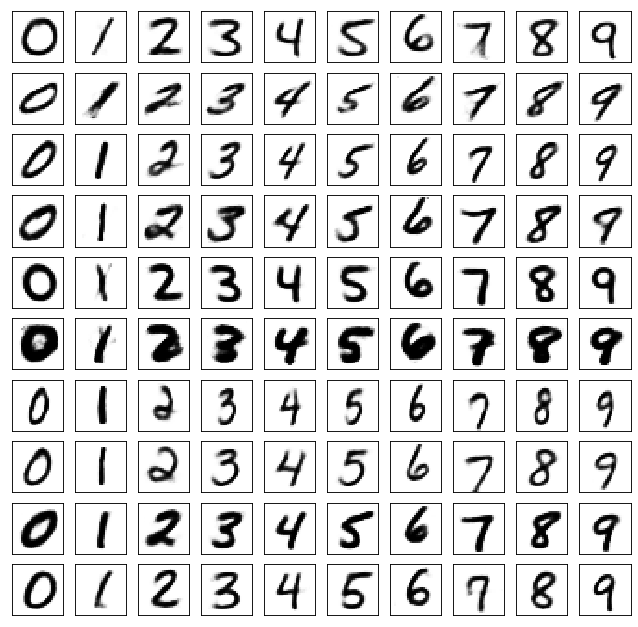

Reconstructed:


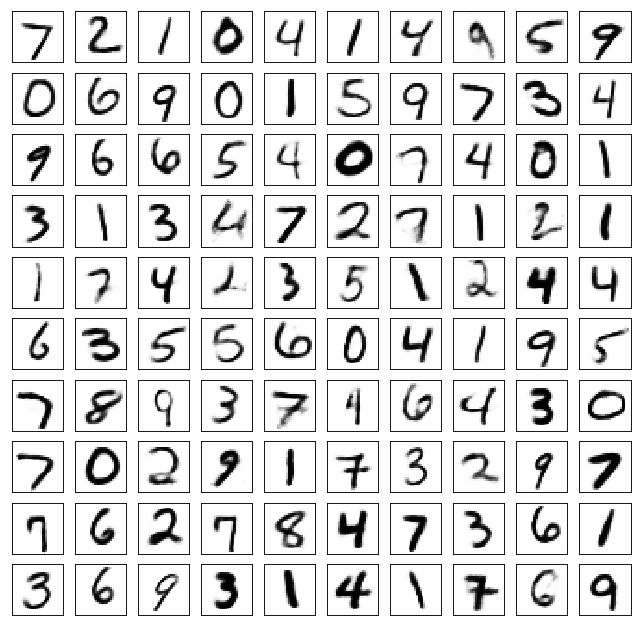

Test losses. E: 0.6882, AE: 0.0485, D: 0.6923
Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6741, AE: 0.9251, D: 0.6903
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.4455, AE: 0.2618, D: 6.4806
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8250, AE: 0.3164, D: 1.5180
Test losses. E: 0.8139, AE: 0.3033, D: 1.5669
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8233, AE: 0.3056, D: 1.5252
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5976, AE: 0.2529, D: 1.0096
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 1.0833, AE: 0.2590, D: 0.8568
Test losses. E: 0.7155, AE: 0.2562, D: 0.8379
Train Epoch: 3 [0/50000 (0%)]	Losses E: 1.0615, AE: 0.2611, D: 0.8952
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6141, AE: 0.2467, D: 0.9445
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5248, AE: 0.2391, D: 0.7610
Test losses. E: 0.5203, AE: 0.2352, D: 0.7574
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5213, AE: 0.2372, D: 0.7677
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.6029, AE: 0.2259, D: 0.7083
Train Ep

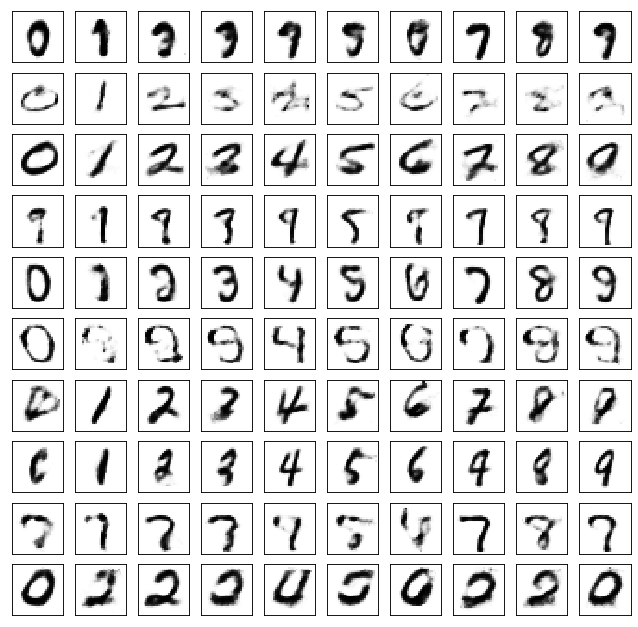

Reconstructed:


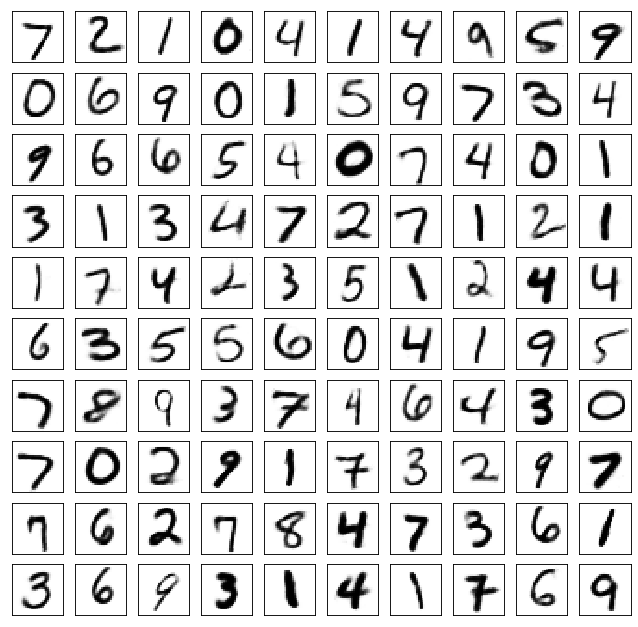

Test losses. E: 0.7021, AE: 0.0420, D: 0.6932


In [139]:
EncFair, DecFair = train_conditional_aae(True)
EncUnfair, DecUnfair = train_conditional_aae(False)

In [142]:
classifiers = {'unfair': Classifier(EncUnfair), 
          'fair': Classifier(EncFair),
          'source': Classifier()}

classifiers_train_log = {k: [] for k in classifiers}
classifiers_test_log = {k: [] for k in classifiers}

In [145]:
for epoch in range(1, 101):
    for model in classifiers.values():
        model.train()
    train_classifiers(epoch, classifiers, classifiers_train_log)
    for model in classifiers.values():
        model.eval()
    test_classifiers(classifiers, classifiers_test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses unfair: 1.740958 fair: 2.408438 source: 0.314659
Train Epoch: 1 [50000/50000 (100%)]	Losses unfair: 1.449402 fair: 2.291843 source: 0.212855
Test set:
unfair: Loss: 1.3949	Accuracy: 5021.0/10000 (50%)
fair: Loss: 2.2858	Accuracy: 1507.0/10000 (15%)
source: Loss: 0.2264	Accuracy: 9320.0/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses unfair: 1.371644 fair: 2.326369 source: 0.257052
Train Epoch: 2 [50000/50000 (100%)]	Losses unfair: 1.337143 fair: 2.266863 source: 0.198860
Test set:
unfair: Loss: 1.3525	Accuracy: 5135.0/10000 (51%)
fair: Loss: 2.2982	Accuracy: 1471.0/10000 (15%)
source: Loss: 0.2214	Accuracy: 9268.0/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses unfair: 1.330034 fair: 2.281619 source: 0.211071
Train Epoch: 3 [50000/50000 (100%)]	Losses unfair: 1.225916 fair: 2.199846 source: 0.160098
Test set:
unfair: Loss: 1.1216	Accuracy: 6218.0/10000 (62%)
fair: Loss: 2.2566	Accuracy: 1740.0/10000 (17%)
source: Loss: 0.1699	Accuracy: 9491.0/10

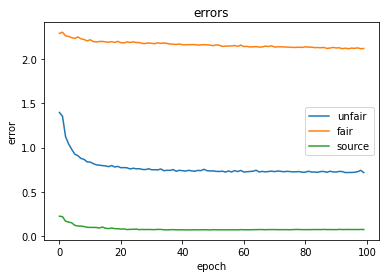

In [146]:
plot_graphs(classifiers_test_log, 'loss')

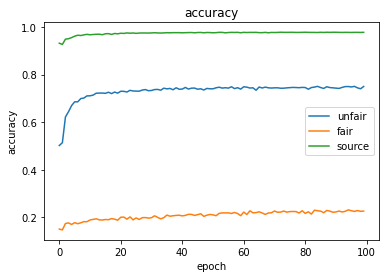

In [147]:
plot_graphs(classifiers_test_log, 'accuracy')

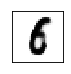

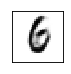

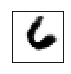

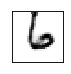

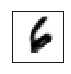

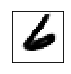

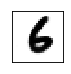

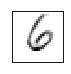

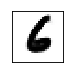

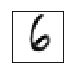

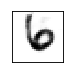

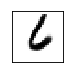

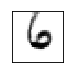

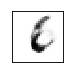

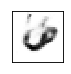

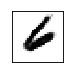

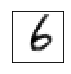

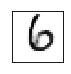

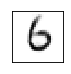

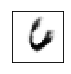

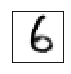

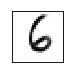

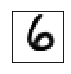

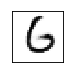

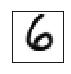

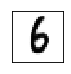

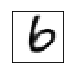

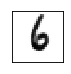

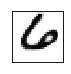

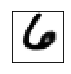

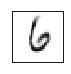

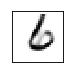

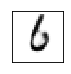

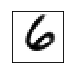

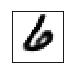

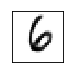

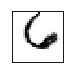

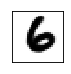

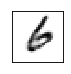

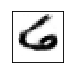

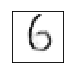

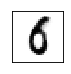

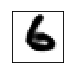

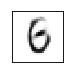

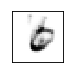

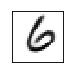

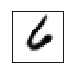

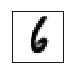

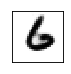

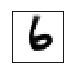

In [148]:
# style transfer
data, target = next(iter(train_loader))
data1, target1 = next(iter(train_loader))

data = data.data.cuda()[:50]
target1 = target1.data.cpu()[:1]

with torch.no_grad():
    i = 0
    while i < 50:
        latent = EncFair(data[i].view(-1, 784))
        label = to_onehot(target1, 10, device)
        i += 1
        reconstructed = DecFair(latent, label).view(-1, 1, 28, 28)

        plot_mnist(reconstructed.cpu(), (10, 10))